# About this notebook
Implement of [Gozsoy's Conditionval VAE code(github)](https://github.com/gozsoy/conditional-vae).
Originaly I imported [Elmisis's VAE code(github)](https://github.com/EleMisi/ConditionalVAE/) to make this [example](https://github.com/chhyyi/rz_cvae) but loss diverges. Also input of attributes(or conditioned input) are not efficient so I found another codes.   

As team decided not to solve this problem cuz deadline of Aiffelthon is DEC 13, there will be no discussion about diverging loss.  

I'll change only some lines of [cvae_example](https://github.com/chhyyi/rz_cvae/blob/main/cvae_expamle.ipynb) and python scripts (actually many part of gozsoy's code is hard coded but I'm not gonna fix that)

## changes for rz\_cvae\_wl
2022-12-07 to process labelled data  
### rz_cvae.Dataset
- added method set_img_include_label(bool), variable img_include_label, path_cols_iter
- changed 'attributes' to 'cond_inputs_col'

In [1]:
import gozsoy_src.model as gmodel
import gozsoy_src.main as gmain
import gozsoy_src.utils as gutils

import tensorflow as tf

# copy of cvae_example
## Load Dataset
dataset class와 모델을 선언합니다. input_table로 넣어주는 파일에 있는 이미지 경로를 읽습니다. Dataset class는 test_set을 저장하는데 이게 나중에 image 생성에 쓰입니다.

In [2]:
# load dataset
import pandas as pd
table_path = "fp_and_cond_input_19to21.csv"

In [3]:
import gozsoy_src.model as gmodel
import gozsoy_src.main as gmain
import gozsoy_src.utils as gutils

import tensorflow as tf
import rz_cvae.Dataset as Dataset
from rz_cvae.utils import save_data
from rz_cvae.CVAE_M1 import CVAE_M1, Decoder, Encoder

learning_rate = 0.001
train_size = 0.5 #between 0.0 ~ 1.0
batch_size = 8
save_test_set = True
# S# True: the test set image IDs and other useful information will be stored in a pickle file to further uses (e.g. Image_Generation.ipynb) 

dataset = Dataset.Dataset(train_size = train_size, 
                          batch_size = batch_size, 
                          input_table = table_path,
                          save_test_set = save_test_set)
label_dim = 26
image_dim = [1024, 1024, 6]
latent_dim = 256

# Model
model = gmodel.Conditional_VAE(latent_dim)

# Optiizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


Loading images id and attributes...
img_ids: 1895 
Attributes: 26 

Splitting dataset...

Train set dimension: 947 
Test set dimension: 948 

<class 'dict'>
Test data successfully saved.


### dataset 의 img_include_label 설정
- dataset.img_include_label(2) : train에는 라벨 폴리곤이 있는 이미지를 넣고, loss계산에서는 라벨 폴리곤이 없는 이미지를 넣으려고 만들었습니다...

In [4]:
dataset.set_img_include_label(2)

[1, 2, 0, 2]

## set checkpoint
checkpoint_root 에서 체크포인트를 저장할 디렉토리를 저장합니다.

In [5]:
import os

# Checkpoint path
checkpoint_root = "./1208_1_{}_{}".format(latent_dim, train_size) 
checkpoint_name = "model"
save_prefix = os.path.join(checkpoint_root, checkpoint_name)

# Define the checkpoint
checkpoint = tf.train.Checkpoint(module=model)


In [22]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import time
from rz_cvae.utils import train_step

beta = 1e-4 #it was too low... but why?? Still I don't understand KL loss.


train_losses = []
train_recon_errors = []
train_latent_losses = []
loss = []
reconstruct_loss = []
latent_loss = []

step_index = 0
n_batches = int(dataset.train_size / batch_size)
n_epochs = 60

print("Number of epochs: {},  number of batches: {}".format(n_epochs, n_batches))

# Epochs Loop
for epoch in range(n_epochs):
    start_time = time.perf_counter()
    dataset.shuffle() # Shuffling
    dataset.set_img_include_label(2)

    # Train Step Loop
    for step_index, inputs in enumerate(dataset):
        imgs_with_label, orig_img = tf.split(inputs[0], num_or_size_splits=2, axis=3)
        # training loop
        with tf.GradientTape() as tape:
            # forward pass
            z_mu,z_rho,decoded_imgs = model(imgs_with_label,inputs[1])

            # compute loss
            mse,kl = gmain.elbo(z_mu,z_rho,decoded_imgs,orig_img)
            total_loss = mse + beta * kl

        # compute gradients
        gradients = tape.gradient(total_loss,model.variables)

        # update weights
        optimizer.apply_gradients(zip(gradients, model.variables))

        # compute loss
        train_losses.append(total_loss)
        train_recon_errors.append(mse)
        train_latent_losses.append(kl)

        if step_index + 1 == n_batches:
            break

    loss.append(np.mean(train_losses, 0))
    reconstruct_loss.append(np.mean(train_recon_errors, 0))
    latent_loss.append(np.mean(train_latent_losses, 0))

    exec_time = time.perf_counter() - start_time
    print("Execution time: %0.3f \t Epoch %i: loss %0.4f | reconstr loss %0.4f | latent loss %0.4f"
                        % (exec_time, epoch, loss[epoch], reconstruct_loss[epoch], latent_loss[epoch])) 

    if np.isnan([loss[-1], reconstruct_loss[-1], latent_loss[-1]]).any():
        print("loss diverged. stop training")
        break
    
    # Save progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint.save(save_prefix + "_" + str(epoch + 1))
        print("Model saved:", save_prefix)

# Save the final model                
checkpoint.save(save_prefix)
print("Model saved:", save_prefix)


     

Number of epochs: 60,  number of batches: 118
IDs shuffled.
Execution time: 189.134 	 Epoch 0: loss 137.8044 | reconstr loss 137.8044 | latent loss 0.0021
IDs shuffled.
Execution time: 178.682 	 Epoch 1: loss 137.8414 | reconstr loss 137.8414 | latent loss 0.0017
IDs shuffled.
Execution time: 179.479 	 Epoch 2: loss 135.1889 | reconstr loss 135.1889 | latent loss 0.0015
IDs shuffled.
Execution time: 179.210 	 Epoch 3: loss 136.1970 | reconstr loss 136.1970 | latent loss 0.0013
IDs shuffled.
Execution time: 178.531 	 Epoch 4: loss 133.2374 | reconstr loss 133.2374 | latent loss 0.0012
Model saved: ./1208_1_256_0.5/model
IDs shuffled.
Execution time: 179.427 	 Epoch 5: loss 134.5854 | reconstr loss 134.5854 | latent loss 0.0012
IDs shuffled.
Execution time: 178.432 	 Epoch 6: loss 135.6816 | reconstr loss 135.6816 | latent loss 0.0011
IDs shuffled.
Execution time: 178.125 	 Epoch 7: loss 134.5675 | reconstr loss 134.5675 | latent loss 0.0011
IDs shuffled.
Execution time: 178.656 	 Epoch 

### 체크포인트에서 복원
 저장된 체크포인트를 보면 data- 파일과 index 파일이 있는데 그 앞의 공통 파일명으로 체크포인트를 restore할 수 있습니다. checkpoint_name을 model로 한 경우 이런 식입니다.
 학습을 끝내고 바로 모델을 이용하면 restore가 필요하지 않습니다.
 (저는 보통 학습 빼고 다 실행한 다음에 restore 했습니다.)

In [23]:
print(os.listdir('1208_1_256_0.5'))

['model_10-2.index', 'model_30-12.index', 'model_45-15.index', 'model_25-11.index', 'model_20-4.data-00000-of-00001', 'model_10-2.data-00000-of-00001', 'model_30-6.index', 'model_5-7.index', 'model_35-13.data-00000-of-00001', 'model_20-10.data-00000-of-00001', 'model_5-7.data-00000-of-00001', 'model_30-6.data-00000-of-00001', 'model-7.data-00000-of-00001', 'model_10-8.index', 'model_20-10.index', 'model_15-9.index', 'model_40-14.data-00000-of-00001', 'model_10-8.data-00000-of-00001', 'model_40-14.index', 'model_15-9.data-00000-of-00001', 'model_45-15.data-00000-of-00001', 'model-19.index', 'model_15-3.index', 'model-7.index', 'model_5-1.index', 'model_55-17.index', 'model_60-18.index', 'model_60-18.data-00000-of-00001', 'model_35-13.index', 'model_50-16.index', 'model_20-4.index', 'model_15-3.data-00000-of-00001', 'model_25-5.data-00000-of-00001', 'model_25-11.data-00000-of-00001', 'checkpoint', 'model-19.data-00000-of-00001', 'model_50-16.data-00000-of-00001', 'model_30-12.data-00000-

In [7]:
checkpoint.restore(os.path.join(checkpoint_root,'model_60-18'))

In [24]:
import argparse
import json
import os
from matplotlib import pyplot as plt
import sys

import tensorflow as tf

from rz_cvae.utils import batch_generator, convert_batch_to_image_grid, read_data

# Read test_data.pickle 
test_data = read_data("./test_data")

원래 batch_generator()의 두 번째 argument는 다음과 같이 test_img_ids를 불러와서 넣었던 겁니다만 train_size=1.0 인 경우 test_img_ids가 없으므로 train_img_ids를 넣어야 돌아갑니다.
```python
    batch_gen = batch_generator(test_data['batch_size'], test_data['test_img_ids'], model_name = 'Conv')

```

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


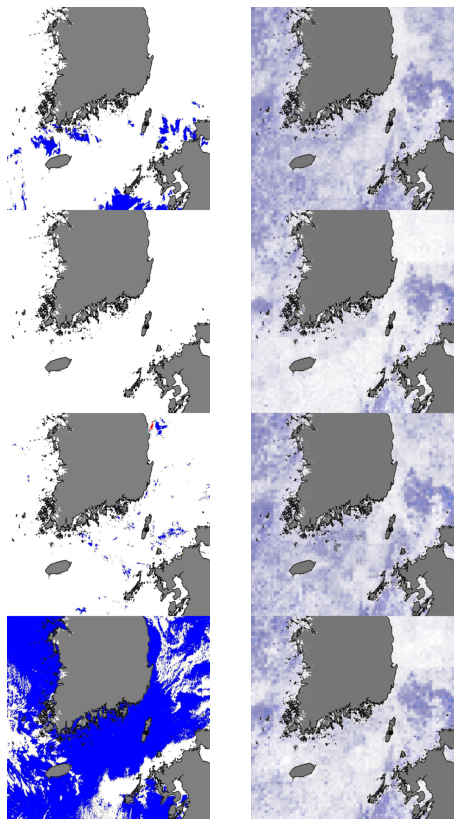

Reconstruction of a batch of test set images:  ['20210925_13_RI.jpg.jpg', '20210925_13_Chl.jpg.jpg', '20210925_14_RI.jpg.jpg', '20210925_14_Chl.jpg.jpg', '20210925_15_RI.jpg.jpg', '20210925_15_Chl.jpg.jpg', '20210925_16_RI.jpg.jpg', '20210925_16_Chl.jpg.jpg', '20210925_17_RI.jpg.jpg', '20210925_17_Chl.jpg.jpg', '20210926_08_RI.jpg.jpg', '20210926_08_Chl.jpg.jpg', '20210926_09_RI.jpg.jpg', '20210926_09_Chl.jpg.jpg', '20210926_10_RI.jpg.jpg', '20210926_10_Chl.jpg.jpg']


<Figure size 432x288 with 0 Axes>

In [25]:
"""
Reconstructs and plots a bacth of test images.
"""

batch_gen = batch_generator(test_data['batch_size'], test_data['test_img_ids'], model_name = 'Conv')
images, labels, paths = next(batch_gen)
_, _, pred_img= model(images, labels)

#print(test_data[''])

f = plt.figure(figsize=(8,20))
ax = f.add_subplot(1,2,1)
ax.imshow(convert_batch_to_image_grid(images, batch_size=8))
plt.axis('off')

ax = f.add_subplot(1,2,2)
ax.imshow(convert_batch_to_image_grid(pred_img.numpy(), batch_size=8))
plt.axis('off')


plt.show()
plt.clf()

print("Reconstruction of a batch of test set images: ", [x.split('/')[-1] for x in paths])

### next(batch_gen)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


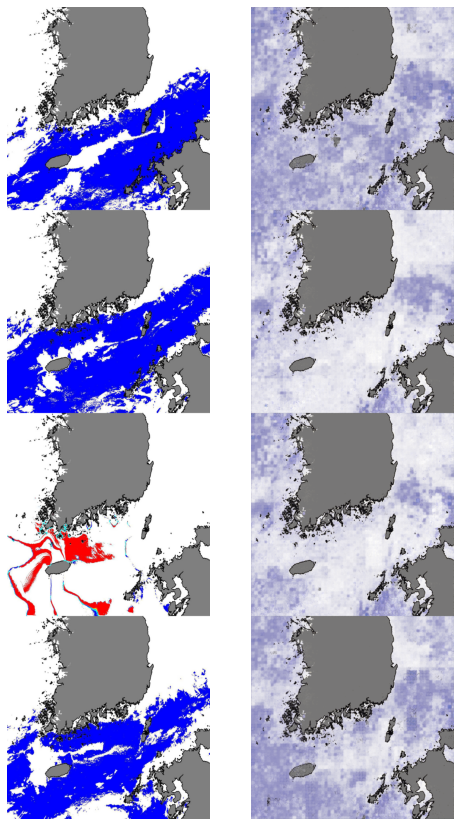

Reconstruction of a batch of test set images:  ['20211008_12_RI.jpg.jpg', '20211008_12_Chl.jpg.jpg', '20211008_13_RI.jpg.jpg', '20211008_13_Chl.jpg.jpg', '20211008_14_RI.jpg.jpg', '20211008_14_Chl.jpg.jpg', '20211008_15_RI.jpg.jpg', '20211008_15_Chl.jpg.jpg', '20211008_16_RI.jpg.jpg', '20211008_16_Chl.jpg.jpg', '20211008_17_RI.jpg.jpg', '20211008_17_Chl.jpg.jpg', '20211009_08_RI.jpg.jpg', '20211009_08_Chl.jpg.jpg', '20211009_09_RI.jpg.jpg', '20211009_09_Chl.jpg.jpg']


<Figure size 432x288 with 0 Axes>

In [27]:
images, labels, paths = next(batch_gen)
for i in range(7):
    images, labels, paths = next(batch_gen)
_, _, pred_img= model(images, labels)

#print(test_data[''])

f = plt.figure(figsize=(8,20))
ax = f.add_subplot(1,2,1)
ax.imshow(convert_batch_to_image_grid(images, batch_size=8, num_plot_imgs=4))
plt.axis('off')

ax = f.add_subplot(1,2,2)
ax.imshow(convert_batch_to_image_grid(pred_img.numpy(), batch_size=8, num_plot_imgs=4))
plt.axis('off')



save_path = False
if save_path :
    plt.savefig(save_path + "reconstruction.png")

plt.show()
plt.clf()

print("Reconstruction of a batch of test set images: ", [x.split('/')[-1] for x in paths])

# dataset에서 바로 이미지 생성 테스트...

In [ ]:
import matplotlib.pyplot as plt
num_gen = 4
batch_size = 4
for step_index, inputs in enumerate(dataset):
    if step_index%7==0:
        imgs_with_label, orig_img = tf.split(inputs[0], num_or_size_splits=2, axis=3)
        _, _, decoded_imgs = model(imgs_with_label,inputs[1])
        for i in range(batch_size):
            f = plt.figure(figsize=(6,4))
            ax = f.add_subplot(1,2,1)
            ax.imshow(tf.split(imgs_with_label, num_or_size_splits=2, axis=3)[0][i])
            plt.axis('off')

            ax = f.add_subplot(1,2,2)
            ax.imshow(tf.split(decoded_imgs, num_or_size_splits=2, axis=3)[0][i])
            plt.axis('off')
            plt.show()
            if i==num_gen-1:
                break
    if step_index>12:
        break
    else:
        continue

In [50]:
print(tf.random.shuffle(range(5), seed=None, name=None).numpy())

[0 1 3 4 2]
